# CORNER TRANSFER matrix

Following the great tutorial by Philippe Corboz [pdf](https://nextcloud.tfk.ph.tum.de/etn/wp-content/uploads/2018/11/Philippe_Corboz.pdf)

## Local Boltzmann weight

We start by defining the local Boltzmann weight
$$M(i,j) = \exp(-\beta(-\sigma_i \sigma_j - 0.5 h(\sigma_i +\sigma_j)))$$


In [3]:
import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt
from ncon import ncon
beta= np.log(1.+np.sqrt(2.))/2.
h = 0.0
#H =- s s -h s
Boltz_weight=np.zeros([2,2])
for s_1 in [0,1]:
    for s_2 in [0,1]:
        sigma_1=2.*(s_1-0.5)
        sigma_2=2.*(s_2-0.5)
        Boltz_weight[s_1,s_2]=(np.exp(beta*sigma_1*sigma_2+
                                           beta*h*0.5*(sigma_1+sigma_2)))

## Local Tensor
 We now build the elementary four legs tensor $$T$$ we will use for the contraction using the Boltzman weight and the copy tensor as in the left part of the figure, we will define a function that accepts two arguments $\beta, h$
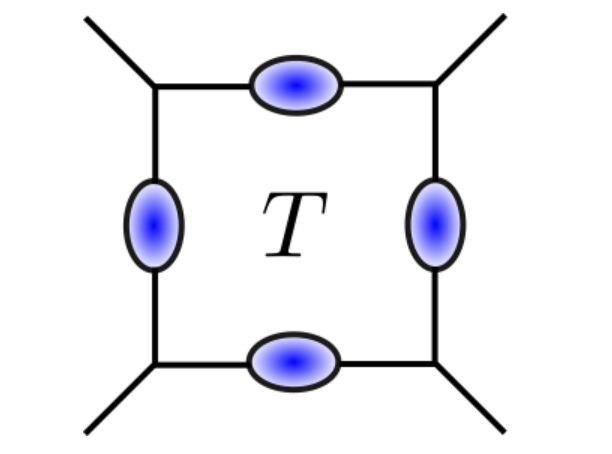

In [4]:
def local_tensor_T(beta, h):
#H =- s s -h s
    Boltz_weight=np.zeros([2,2])
    for s_1 in [0,1]:
        for s_2 in [0,1]:
            sigma_1=2.*(s_1-0.5)
            sigma_2=2.*(s_2-0.5)
            Boltz_weight[s_1,s_2]=(np.exp(beta*sigma_1*sigma_2+
                                               beta*h*0.5*(sigma_1+sigma_2)))    

    
    
    copy_3= np.zeros([2,2,2])
    #copy_4= np.zeros([2,2,2,2])
    
    for s in [0,1]:
        copy_3[s,s,s]=1.
        #copy_4[s,s,s,s]=1.
    
    list_tensors =[copy_3,
                   Boltz_weight,
                   copy_3,
                   Boltz_weight,
                   copy_3,
                   Boltz_weight,
                   copy_3,
                   Boltz_weight]    
    list_indices =[[-1,1,8],[1,2],[2,-2,3],[3,4],
                    [4,-3,5],[5,6],[6,-4,7],[7,8]]
    tensor_z_two_dim = ncon(list_tensors,list_indices)
    return tensor_z_two_dim

## Building blocks
Now  we need to code the two functions that perform the contraction of the partition function and the numerator for the magnetization, 
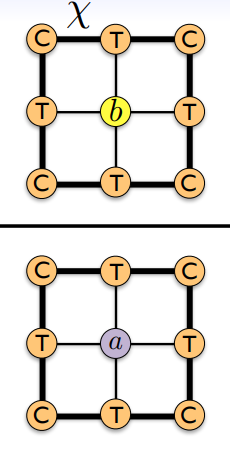

*** In this plot $$ a=T $$ of the previous figure
 $$C$$ and $$T$$,can be initialized as slices of $a$ as if some of the boundary spins of $a$, where set to $\uparrow$ (corresponding to the state $0$)
 
 we define two functions, one that compute the numerator and the other the denominator. The first will accept as input $ C, T, a$ while the second also requires $b$, as an alternative we can define also a function that compute both numerator and denominator and takes the ratio, to directly returnt the magnetization

## Exercice 1 
Fill the missing lines in the code to provide the correct tensor contractions for both numerator and denominator of the calculation of the magnetization (the tensor networks in the previous drawing). 

The ordering of the legs for the tensors is given in the figure and all $C$ and all $T$ are the same. 

![](../pictures/ctm_ingredients_ord.png)

In [5]:
def compute_norm(C,T,a):
    list_tensors=[C,C,C,C,T,T,T,T,a]
    list_indices=[[7,8],[1,2],[3,4],[5,6],
                     [8,12,1],[2,9,3],[4,10,5],[6,11,7],
                     [11,12,9,10]]
    norm=ncon(list_tensors,list_indices)
    return(norm)
def compute_mag(C,T,a,b):
    list_tensors=[C,C,C,C,T,T,T,T,a]
    list_indices=[[7,8],[1,2],[3,4],[5,6],
                 [8,12,1],[2,9,3],[4,10,5],[6,11,7],
                 [11,12,9,10]]
    norm=ncon(list_tensors,list_indices)
    list_tensors=[C,C,C,C,T,T,T,T,b]
    numerator=ncon(list_tensors,list_indices)
    return(numerator/norm)

## One step

Now the core of the CTM algortihm is to renormalize the $C$ and $T$ until a fixed point is obtained. 
This is done by absorbing at each step an extra $a$ into $C$ and $T$ and then truncating the resulting tensor so that their size is upperbounded by maximal bond dimension 
$$\chi \le \chi_{max}$$

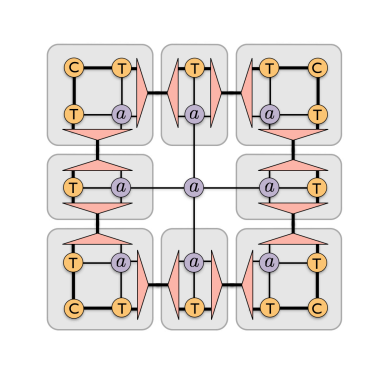

The recipy to project back is based on the spectrum of the CTM $C$

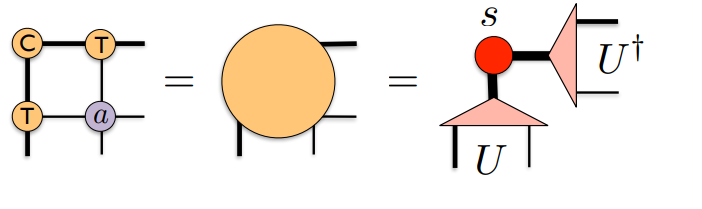

For stability reasons, it is important to keep norms and tensor bounded (by finding an adequate normalization step) and to keep the corner symmetric, such that one can use an eigenvalue decomposition rather than an svd. 

The projector thus project on the largest eigenvalues of the corner 

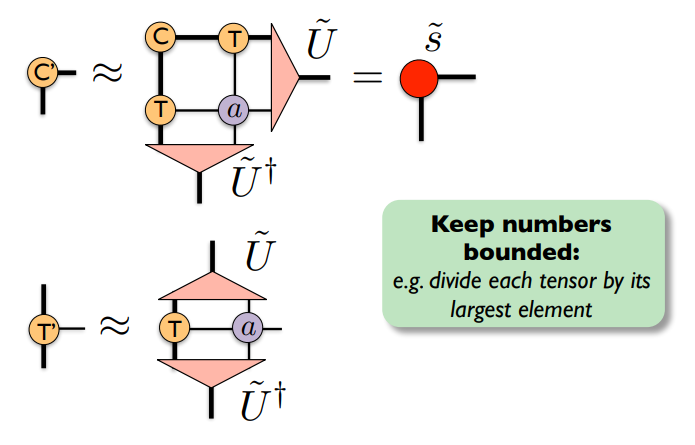

The function that perfrom such step requires, $C$, $T$, $a$, $d$,the size of $a$ $\chi$,the size of the corner $\chi_{max}$, the maximal size of the corner, d_tol, the cutoff on the eigenvalues. 

The size of the corner will grow up to $\chi_{max}$ by including all eigenvalues of the corner up to d_tol, the new chi should also be returned

In [37]:
def one_step_ctm(C,T,a,d,chi,chi_max,d_tol):
    Cp = ncon([C, T, T, a],[[2, 1], [1 ,3, -3], [-1,4,2],
                            [-2,4,3,-4]]).reshape(chi*d,chi*d)
    #print(T[:,0,:]-T[:,0,:].T)
    np.allclose(Cp,Cp.T)
    Cp =0.5*(Cp+Cp.T)
    e_c, U_c =LA.eigh(Cp)
    n_cp=np.max(e_c)
    Cp=Cp/n_cp
    e_c, U_c =LA.eigh(Cp)
    #print(max(e_c))
    Tp = ncon([T,a],[[-1,1,-4],[-3,-2,1,-5]]).reshape(chi*d,d,chi*d)
    Tp=Tp/n_cp
    chitemp = sum(e_c/np.max(e_c) > d_tol)
    chi= min(chitemp,chi_max)
    U_c= U_c[:, range(-1, -chi - 1, -1)]
    #print(chi)
    C=U_c.T.conj()@Cp@U_c
    T=ncon([U_c.T.conj(),U_c,Tp],
          [[-1,1],[2,-3],[1,-2,2]]) 
    return C, T,chi,e_c[range(-1, -chi - 1, -1)]



            

In order to compare with the exact result we need to compute also the exact magnetization for $\beta\ge \beta_c$ given by 
$$M = \left[ 1 - \sinh^{-4}(2 \beta) \right]^{1/8}$$ 



In [41]:


def exact_mag(beta):
    return (1 - np.sinh(2*beta)**(-4))**(1/8)

## Exercice 2
Now define a function that iterate the steps of the the CTM untill the svds of the corner have converged to a given precision, it should also have a maximum number of iteration and abort the calculation past that maximum number. Both the precision and the maximum number should be arguments of the function. 

In [46]:
def iterate_till_convergence(C,T,a,d,chi,chi_max,d_tol,conv_crit,kmax):
    e_c= np.zeros(chi)
    chi_n =chi
    err_ctm =1. 
    k=0
    while(err_ctm >= conv_crit):
        
        k=k+1
        C, T,chi_n,e_cn = one_step_ctm(C,T,a,d,chi_n,chi_max,d_tol)
        if e_c.shape[0] != e_cn.shape[0]:
            e_c=np.zeros(e_cn.shape[0])
        err_ctm = LA.norm(e_c-e_cn)
        e_c =e_cn
        print('Iteration : %d, error =%g'% (k,err_ctm))
        if k > kmax:
            print('Max iterations reached,residual error : %g' %(err_ctm) )
            break
        norm = compute_norm(C,T,a)
        C= C/norm**(1/9)
        T = T/norm**(1/9)   
    return C,T,chi_n,k


## All together, several iterations

Now we can put all together, since the CTM is an iterative method one should take care about the convergence, by e.g. tracking the magnetization and repeating the algorithm untill it stop changing (up to a desired accuracy). For simplicity here we will fix the number of iteration to 40 and run the program for different $\beta$. 

In [51]:
d_tol=1.e-10
conv_crit =1.e-5
numiter_max=1000
list_mag=[]
beta_start=0.42
b_fin=0.5
num_steps=100
d=2
chi_max=4
x = np.linspace(beta_start,b_fin,num_steps)
for beta in x:
    a=local_tensor_T(beta,0)
    b=a.copy()
    b[1,:,:,:]=-b[1,:,:,:]
    C = a[:,:,0,0]
    T = a[:,:,0,:]
    chi = d
    T = T+T.transpose([2,1,0])
    norm = compute_norm(C,T,a)
    C= C/norm**(1/9)
    T = T/norm**(1/9)
    C,T,chi,k= iterate_till_convergence(C,T,a,d,chi,chi_max,d_tol,conv_crit,numiter_max)
    norm = compute_norm(C,T,a)
    magnetization = compute_mag(C,T,a,b)
    print('Conv. in %d, final norm: %g, mag %g, chi %d'% (k,norm, magnetization,chi))
    list_mag.append(magnetization)


Iteration : 1, error =1.02354
Iteration : 2, error =0.0667366
Iteration : 3, error =0.0473808
Iteration : 4, error =0.0368997
Iteration : 5, error =0.0303969
Iteration : 6, error =0.0258665
Iteration : 7, error =0.0224501
Iteration : 8, error =0.0197207
Iteration : 9, error =0.0174443
Iteration : 10, error =0.0154842
Iteration : 11, error =0.0137575
Iteration : 12, error =0.0122129
Iteration : 13, error =0.010818
Iteration : 14, error =0.00955235
Iteration : 15, error =0.00840282
Iteration : 16, error =0.00736042
Iteration : 17, error =0.00641853
Iteration : 18, error =0.00557158
Iteration : 19, error =0.00481431
Iteration : 20, error =0.00414137
Iteration : 21, error =0.00354712
Iteration : 22, error =0.00302563
Iteration : 23, error =0.00257078
Iteration : 24, error =0.00217637
Iteration : 25, error =0.00183623
Iteration : 26, error =0.0015444
Iteration : 27, error =0.00129521
Iteration : 28, error =0.00108336
Iteration : 29, error =0.000903974
Iteration : 30, error =0.000752636
Iter

Iteration : 22, error =0.00434047
Iteration : 23, error =0.00384004
Iteration : 24, error =0.00338714
Iteration : 25, error =0.002979
Iteration : 26, error =0.00261275
Iteration : 27, error =0.00228545
Iteration : 28, error =0.00199413
Iteration : 29, error =0.00173582
Iteration : 30, error =0.00150762
Iteration : 31, error =0.00130671
Iteration : 32, error =0.00113038
Iteration : 33, error =0.000976103
Iteration : 34, error =0.000841483
Iteration : 35, error =0.000724321
Iteration : 36, error =0.000622595
Iteration : 37, error =0.000534464
Iteration : 38, error =0.000458264
Iteration : 39, error =0.000392501
Iteration : 40, error =0.000335841
Iteration : 41, error =0.0002871
Iteration : 42, error =0.000245229
Iteration : 43, error =0.000209306
Iteration : 44, error =0.000178522
Iteration : 45, error =0.00015217
Iteration : 46, error =0.000129635
Iteration : 47, error =0.000110379
Iteration : 48, error =9.39395e-05
Iteration : 49, error =7.99142e-05
Iteration : 50, error =6.79565e-05
I

Iteration : 1, error =1.02258
Iteration : 2, error =0.0641127
Iteration : 3, error =0.0449328
Iteration : 4, error =0.0346772
Iteration : 5, error =0.028426
Iteration : 6, error =0.0241791
Iteration : 7, error =0.0210779
Iteration : 8, error =0.0186919
Iteration : 9, error =0.0167811
Iteration : 10, error =0.0152009
Iteration : 11, error =0.0138595
Iteration : 12, error =0.0126957
Iteration : 13, error =0.0116678
Iteration : 14, error =0.0107465
Iteration : 15, error =0.00991066
Iteration : 16, error =0.00914518
Iteration : 17, error =0.00843892
Iteration : 18, error =0.00778369
Iteration : 19, error =0.00717344
Iteration : 20, error =0.00660363
Iteration : 21, error =0.00607086
Iteration : 22, error =0.00557251
Iteration : 23, error =0.00510654
Iteration : 24, error =0.00467128
Iteration : 25, error =0.00426531
Iteration : 26, error =0.00388737
Iteration : 27, error =0.00353628
Iteration : 28, error =0.0032109
Iteration : 29, error =0.00291009
Iteration : 30, error =0.00263271
Iterati

Conv. in 87, final norm: 1.47471, mag 0.0112931, chi 4
Iteration : 1, error =1.02223
Iteration : 2, error =0.0630943
Iteration : 3, error =0.0439555
Iteration : 4, error =0.0337525
Iteration : 5, error =0.0275561
Iteration : 6, error =0.0233691
Iteration : 7, error =0.0203341
Iteration : 8, error =0.0180209
Iteration : 9, error =0.0161893
Iteration : 10, error =0.0146944
Iteration : 11, error =0.0134436
Iteration : 12, error =0.012375
Iteration : 13, error =0.0114457
Iteration : 14, error =0.0106251
Iteration : 15, error =0.00989117
Iteration : 16, error =0.00922723
Iteration : 17, error =0.00862091
Iteration : 18, error =0.00806272
Iteration : 19, error =0.00754538
Iteration : 20, error =0.00706325
Iteration : 21, error =0.00661192
Iteration : 22, error =0.00618794
Iteration : 23, error =0.00578861
Iteration : 24, error =0.00541176
Iteration : 25, error =0.00505568
Iteration : 26, error =0.00471898
Iteration : 27, error =0.00440054
Iteration : 28, error =0.00409941
Iteration : 29, err

Iteration : 61, error =0.000475041
Iteration : 62, error =0.000439434
Iteration : 63, error =0.000406358
Iteration : 64, error =0.000375648
Iteration : 65, error =0.000347153
Iteration : 66, error =0.000320725
Iteration : 67, error =0.000296228
Iteration : 68, error =0.00027353
Iteration : 69, error =0.000252509
Iteration : 70, error =0.000233049
Iteration : 71, error =0.000215041
Iteration : 72, error =0.000198384
Iteration : 73, error =0.000182981
Iteration : 74, error =0.000168743
Iteration : 75, error =0.000155585
Iteration : 76, error =0.000143431
Iteration : 77, error =0.000132205
Iteration : 78, error =0.000121841
Iteration : 79, error =0.000112273
Iteration : 80, error =0.000103444
Iteration : 81, error =9.5298e-05
Iteration : 82, error =8.77834e-05
Iteration : 83, error =8.08529e-05
Iteration : 84, error =7.44622e-05
Iteration : 85, error =6.85703e-05
Iteration : 86, error =6.31391e-05
Iteration : 87, error =5.81334e-05
Iteration : 88, error =5.35205e-05
Iteration : 89, error 

Iteration : 121, error =1.91753e-05
Iteration : 122, error =1.7954e-05
Iteration : 123, error =1.68103e-05
Iteration : 124, error =1.57391e-05
Iteration : 125, error =1.4736e-05
Iteration : 126, error =1.37966e-05
Iteration : 127, error =1.2917e-05
Iteration : 128, error =1.20933e-05
Iteration : 129, error =1.13219e-05
Iteration : 130, error =1.05997e-05
Iteration : 131, error =9.9234e-06
Conv. in 131, final norm: 1.48325, mag 0.0154259, chi 4
Iteration : 1, error =1.02163
Iteration : 2, error =0.0613649
Iteration : 3, error =0.0422737
Iteration : 4, error =0.0321315
Iteration : 5, error =0.0259936
Iteration : 6, error =0.021867
Iteration : 7, error =0.0188966
Iteration : 8, error =0.0166534
Iteration : 9, error =0.0148974
Iteration : 10, error =0.0134839
Iteration : 11, error =0.0123201
Iteration : 12, error =0.0113437
Iteration : 13, error =0.0105117
Iteration : 14, error =0.00979299
Iteration : 15, error =0.00916471
Iteration : 16, error =0.00860977
Iteration : 17, error =0.00811502

Iteration : 87, error =0.000446614
Iteration : 88, error =0.000426904
Iteration : 89, error =0.000408008
Iteration : 90, error =0.000389897
Iteration : 91, error =0.000372542
Iteration : 92, error =0.000355915
Iteration : 93, error =0.000339989
Iteration : 94, error =0.000324739
Iteration : 95, error =0.000310137
Iteration : 96, error =0.00029616
Iteration : 97, error =0.000282782
Iteration : 98, error =0.000269982
Iteration : 99, error =0.000257736
Iteration : 100, error =0.000246022
Iteration : 101, error =0.000234818
Iteration : 102, error =0.000224106
Iteration : 103, error =0.000213864
Iteration : 104, error =0.000204073
Iteration : 105, error =0.000194715
Iteration : 106, error =0.000185772
Iteration : 107, error =0.000177227
Iteration : 108, error =0.000169063
Iteration : 109, error =0.000161264
Iteration : 110, error =0.000153815
Iteration : 111, error =0.000146701
Iteration : 112, error =0.000139907
Iteration : 113, error =0.000133421
Iteration : 114, error =0.000127227
Iterat

Iteration : 190, error =1.15885e-05
Iteration : 191, error =1.11322e-05
Iteration : 192, error =1.06938e-05
Iteration : 193, error =1.02727e-05
Iteration : 194, error =9.8681e-06
Conv. in 194, final norm: 1.48954, mag 0.0197421, chi 4
Iteration : 1, error =1.02128
Iteration : 2, error =0.0603117
Iteration : 3, error =0.04124
Iteration : 4, error =0.0311231
Iteration : 5, error =0.0250065
Iteration : 6, error =0.0208998
Iteration : 7, error =0.0179493
Iteration : 8, error =0.0157266
Iteration : 9, error =0.013992
Iteration : 10, error =0.0126009
Iteration : 11, error =0.0114607
Iteration : 12, error =0.0105092
Iteration : 13, error =0.0097032
Iteration : 14, error =0.0090117
Iteration : 15, error =0.00841184
Iteration : 16, error =0.00788645
Iteration : 17, error =0.00742235
Iteration : 18, error =0.00700928
Iteration : 19, error =0.00663912
Iteration : 20, error =0.00630538
Iteration : 21, error =0.00600279
Iteration : 22, error =0.00572703
Iteration : 23, error =0.00547455
Iteration :

Iteration : 11, error =0.0111538
Iteration : 12, error =0.0102073
Iteration : 13, error =0.00940639
Iteration : 14, error =0.00872015
Iteration : 15, error =0.00812573
Iteration : 16, error =0.00760594
Iteration : 17, error =0.0071476
Iteration : 18, error =0.00674044
Iteration : 19, error =0.00637636
Iteration : 20, error =0.00604883
Iteration : 21, error =0.0057526
Iteration : 22, error =0.00548334
Iteration : 23, error =0.00523751
Iteration : 24, error =0.00501211
Iteration : 25, error =0.00480467
Iteration : 26, error =0.00461306
Iteration : 27, error =0.00443551
Iteration : 28, error =0.00427046
Iteration : 29, error =0.0041166
Iteration : 30, error =0.00397278
Iteration : 31, error =0.00383801
Iteration : 32, error =0.00371141
Iteration : 33, error =0.00359222
Iteration : 34, error =0.00347977
Iteration : 35, error =0.00337347
Iteration : 36, error =0.00327279
Iteration : 37, error =0.00317726
Iteration : 38, error =0.00308646
Iteration : 39, error =0.00300002
Iteration : 40, err

Iteration : 262, error =1.98504e-05
Iteration : 263, error =1.93892e-05
Iteration : 264, error =1.89387e-05
Iteration : 265, error =1.84986e-05
Iteration : 266, error =1.80687e-05
Iteration : 267, error =1.76488e-05
Iteration : 268, error =1.72385e-05
Iteration : 269, error =1.68378e-05
Iteration : 270, error =1.64463e-05
Iteration : 271, error =1.60639e-05
Iteration : 272, error =1.56904e-05
Iteration : 273, error =1.53255e-05
Iteration : 274, error =1.49691e-05
Iteration : 275, error =1.46209e-05
Iteration : 276, error =1.42808e-05
Iteration : 277, error =1.39486e-05
Iteration : 278, error =1.36241e-05
Iteration : 279, error =1.33071e-05
Iteration : 280, error =1.29975e-05
Iteration : 281, error =1.2695e-05
Iteration : 282, error =1.23996e-05
Iteration : 283, error =1.2111e-05
Iteration : 284, error =1.18291e-05
Iteration : 285, error =1.15538e-05
Iteration : 286, error =1.12849e-05
Iteration : 287, error =1.10222e-05
Iteration : 288, error =1.07656e-05
Iteration : 289, error =1.0514

Iteration : 220, error =0.000148314
Iteration : 221, error =0.000146096
Iteration : 222, error =0.000143909
Iteration : 223, error =0.000141755
Iteration : 224, error =0.000139633
Iteration : 225, error =0.000137541
Iteration : 226, error =0.00013548
Iteration : 227, error =0.000133449
Iteration : 228, error =0.000131448
Iteration : 229, error =0.000129477
Iteration : 230, error =0.000127534
Iteration : 231, error =0.00012562
Iteration : 232, error =0.000123734
Iteration : 233, error =0.000121876
Iteration : 234, error =0.000120045
Iteration : 235, error =0.000118241
Iteration : 236, error =0.000116463
Iteration : 237, error =0.000114712
Iteration : 238, error =0.000112986
Iteration : 239, error =0.000111286
Iteration : 240, error =0.000109611
Iteration : 241, error =0.000107961
Iteration : 242, error =0.000106335
Iteration : 243, error =0.000104733
Iteration : 244, error =0.000103155
Iteration : 245, error =0.0001016
Iteration : 246, error =0.000100068
Iteration : 247, error =9.85591e

Iteration : 83, error =0.00107265
Iteration : 84, error =0.00105708
Iteration : 85, error =0.00104189
Iteration : 86, error =0.00102705
Iteration : 87, error =0.00101256
Iteration : 88, error =0.000998407
Iteration : 89, error =0.000984575
Iteration : 90, error =0.000971055
Iteration : 91, error =0.000957835
Iteration : 92, error =0.000944907
Iteration : 93, error =0.00093226
Iteration : 94, error =0.000919885
Iteration : 95, error =0.000907773
Iteration : 96, error =0.000895916
Iteration : 97, error =0.000884305
Iteration : 98, error =0.000872934
Iteration : 99, error =0.000861793
Iteration : 100, error =0.000850878
Iteration : 101, error =0.00084018
Iteration : 102, error =0.000829692
Iteration : 103, error =0.00081941
Iteration : 104, error =0.000809326
Iteration : 105, error =0.000799435
Iteration : 106, error =0.000789731
Iteration : 107, error =0.000780209
Iteration : 108, error =0.000770864
Iteration : 109, error =0.00076169
Iteration : 110, error =0.000752684
Iteration : 111, e

Iteration : 331, error =0.00010726
Iteration : 332, error =0.000106426
Iteration : 333, error =0.000105599
Iteration : 334, error =0.000104779
Iteration : 335, error =0.000103965
Iteration : 336, error =0.000103158
Iteration : 337, error =0.000102357
Iteration : 338, error =0.000101562
Iteration : 339, error =0.000100774
Iteration : 340, error =9.99927e-05
Iteration : 341, error =9.92173e-05
Iteration : 342, error =9.84482e-05
Iteration : 343, error =9.76851e-05
Iteration : 344, error =9.69282e-05
Iteration : 345, error =9.61774e-05
Iteration : 346, error =9.54326e-05
Iteration : 347, error =9.46937e-05
Iteration : 348, error =9.39607e-05
Iteration : 349, error =9.32336e-05
Iteration : 350, error =9.25123e-05
Iteration : 351, error =9.17967e-05
Iteration : 352, error =9.10869e-05
Iteration : 353, error =9.03827e-05
Iteration : 354, error =8.96841e-05
Iteration : 355, error =8.89911e-05
Iteration : 356, error =8.83035e-05
Iteration : 357, error =8.76215e-05
Iteration : 358, error =8.694

Iteration : 590, error =1.47242e-05
Iteration : 591, error =1.46126e-05
Iteration : 592, error =1.45018e-05
Iteration : 593, error =1.43919e-05
Iteration : 594, error =1.42828e-05
Iteration : 595, error =1.41745e-05
Iteration : 596, error =1.4067e-05
Iteration : 597, error =1.39604e-05
Iteration : 598, error =1.38546e-05
Iteration : 599, error =1.37496e-05
Iteration : 600, error =1.36454e-05
Iteration : 601, error =1.35419e-05
Iteration : 602, error =1.34393e-05
Iteration : 603, error =1.33374e-05
Iteration : 604, error =1.32364e-05
Iteration : 605, error =1.3136e-05
Iteration : 606, error =1.30365e-05
Iteration : 607, error =1.29377e-05
Iteration : 608, error =1.28396e-05
Iteration : 609, error =1.27423e-05
Iteration : 610, error =1.26458e-05
Iteration : 611, error =1.25499e-05
Iteration : 612, error =1.24548e-05
Iteration : 613, error =1.23604e-05
Iteration : 614, error =1.22668e-05
Iteration : 615, error =1.21738e-05
Iteration : 616, error =1.20816e-05
Iteration : 617, error =1.199e

Iteration : 187, error =0.000296223
Iteration : 188, error =0.000293979
Iteration : 189, error =0.000291763
Iteration : 190, error =0.000289573
Iteration : 191, error =0.00028741
Iteration : 192, error =0.000285273
Iteration : 193, error =0.000283162
Iteration : 194, error =0.000281076
Iteration : 195, error =0.000279014
Iteration : 196, error =0.000276977
Iteration : 197, error =0.000274964
Iteration : 198, error =0.000272974
Iteration : 199, error =0.000271008
Iteration : 200, error =0.000269064
Iteration : 201, error =0.000267143
Iteration : 202, error =0.000265244
Iteration : 203, error =0.000263366
Iteration : 204, error =0.00026151
Iteration : 205, error =0.000259675
Iteration : 206, error =0.00025786
Iteration : 207, error =0.000256066
Iteration : 208, error =0.000254292
Iteration : 209, error =0.000252537
Iteration : 210, error =0.000250802
Iteration : 211, error =0.000249087
Iteration : 212, error =0.00024739
Iteration : 213, error =0.000245711
Iteration : 214, error =0.000244

Iteration : 439, error =8.23967e-05
Iteration : 440, error =8.21018e-05
Iteration : 441, error =8.18085e-05
Iteration : 442, error =8.15169e-05
Iteration : 443, error =8.12269e-05
Iteration : 444, error =8.09385e-05
Iteration : 445, error =8.06517e-05
Iteration : 446, error =8.03664e-05
Iteration : 447, error =8.00828e-05
Iteration : 448, error =7.98007e-05
Iteration : 449, error =7.95201e-05
Iteration : 450, error =7.92411e-05
Iteration : 451, error =7.89636e-05
Iteration : 452, error =7.86876e-05
Iteration : 453, error =7.84132e-05
Iteration : 454, error =7.81402e-05
Iteration : 455, error =7.78687e-05
Iteration : 456, error =7.75986e-05
Iteration : 457, error =7.73301e-05
Iteration : 458, error =7.70629e-05
Iteration : 459, error =7.67972e-05
Iteration : 460, error =7.6533e-05
Iteration : 461, error =7.62701e-05
Iteration : 462, error =7.60087e-05
Iteration : 463, error =7.57486e-05
Iteration : 464, error =7.54899e-05
Iteration : 465, error =7.52327e-05
Iteration : 466, error =7.497

Iteration : 704, error =3.83785e-05
Iteration : 705, error =3.82882e-05
Iteration : 706, error =3.81983e-05
Iteration : 707, error =3.81086e-05
Iteration : 708, error =3.80193e-05
Iteration : 709, error =3.79303e-05
Iteration : 710, error =3.78417e-05
Iteration : 711, error =3.77533e-05
Iteration : 712, error =3.76653e-05
Iteration : 713, error =3.75776e-05
Iteration : 714, error =3.74902e-05
Iteration : 715, error =3.74031e-05
Iteration : 716, error =3.73163e-05
Iteration : 717, error =3.72298e-05
Iteration : 718, error =3.71437e-05
Iteration : 719, error =3.70578e-05
Iteration : 720, error =3.69723e-05
Iteration : 721, error =3.6887e-05
Iteration : 722, error =3.68021e-05
Iteration : 723, error =3.67174e-05
Iteration : 724, error =3.66331e-05
Iteration : 725, error =3.6549e-05
Iteration : 726, error =3.64653e-05
Iteration : 727, error =3.63818e-05
Iteration : 728, error =3.62987e-05
Iteration : 729, error =3.62158e-05
Iteration : 730, error =3.61332e-05
Iteration : 731, error =3.6050

Iteration : 954, error =2.30006e-05
Iteration : 955, error =2.29594e-05
Iteration : 956, error =2.29184e-05
Iteration : 957, error =2.28774e-05
Iteration : 958, error =2.28366e-05
Iteration : 959, error =2.27959e-05
Iteration : 960, error =2.27553e-05
Iteration : 961, error =2.27148e-05
Iteration : 962, error =2.26744e-05
Iteration : 963, error =2.26341e-05
Iteration : 964, error =2.25939e-05
Iteration : 965, error =2.25539e-05
Iteration : 966, error =2.25139e-05
Iteration : 967, error =2.24741e-05
Iteration : 968, error =2.24343e-05
Iteration : 969, error =2.23947e-05
Iteration : 970, error =2.23552e-05
Iteration : 971, error =2.23158e-05
Iteration : 972, error =2.22765e-05
Iteration : 973, error =2.22373e-05
Iteration : 974, error =2.21982e-05
Iteration : 975, error =2.21592e-05
Iteration : 976, error =2.21203e-05
Iteration : 977, error =2.20815e-05
Iteration : 978, error =2.20428e-05
Iteration : 979, error =2.20042e-05
Iteration : 980, error =2.19658e-05
Iteration : 981, error =2.19

Iteration : 194, error =0.000140389
Iteration : 195, error =0.000138786
Iteration : 196, error =0.000137205
Iteration : 197, error =0.000135646
Iteration : 198, error =0.000134108
Iteration : 199, error =0.000132591
Iteration : 200, error =0.000131094
Iteration : 201, error =0.000129617
Iteration : 202, error =0.00012816
Iteration : 203, error =0.000126723
Iteration : 204, error =0.000125304
Iteration : 205, error =0.000123905
Iteration : 206, error =0.000122524
Iteration : 207, error =0.000121161
Iteration : 208, error =0.000119816
Iteration : 209, error =0.000118488
Iteration : 210, error =0.000117178
Iteration : 211, error =0.000115885
Iteration : 212, error =0.000114609
Iteration : 213, error =0.000113349
Iteration : 214, error =0.000112106
Iteration : 215, error =0.000110878
Iteration : 216, error =0.000109667
Iteration : 217, error =0.00010847
Iteration : 218, error =0.000107289
Iteration : 219, error =0.000106123
Iteration : 220, error =0.000104972
Iteration : 221, error =0.0001

Iteration : 423, error =1.42908e-05
Iteration : 424, error =1.41589e-05
Iteration : 425, error =1.40283e-05
Iteration : 426, error =1.38989e-05
Iteration : 427, error =1.37707e-05
Iteration : 428, error =1.36438e-05
Iteration : 429, error =1.3518e-05
Iteration : 430, error =1.33935e-05
Iteration : 431, error =1.32701e-05
Iteration : 432, error =1.31479e-05
Iteration : 433, error =1.30268e-05
Iteration : 434, error =1.29069e-05
Iteration : 435, error =1.27881e-05
Iteration : 436, error =1.26705e-05
Iteration : 437, error =1.25539e-05
Iteration : 438, error =1.24385e-05
Iteration : 439, error =1.23241e-05
Iteration : 440, error =1.22109e-05
Iteration : 441, error =1.20987e-05
Iteration : 442, error =1.19875e-05
Iteration : 443, error =1.18774e-05
Iteration : 444, error =1.17683e-05
Iteration : 445, error =1.16603e-05
Iteration : 446, error =1.15532e-05
Iteration : 447, error =1.14472e-05
Iteration : 448, error =1.13422e-05
Iteration : 449, error =1.12381e-05
Iteration : 450, error =1.113

Iteration : 226, error =2.56499e-05
Iteration : 227, error =2.5172e-05
Iteration : 228, error =2.47031e-05
Iteration : 229, error =2.42432e-05
Iteration : 230, error =2.3792e-05
Iteration : 231, error =2.33493e-05
Iteration : 232, error =2.2915e-05
Iteration : 233, error =2.24889e-05
Iteration : 234, error =2.20709e-05
Iteration : 235, error =2.16607e-05
Iteration : 236, error =2.12583e-05
Iteration : 237, error =2.08635e-05
Iteration : 238, error =2.04762e-05
Iteration : 239, error =2.00961e-05
Iteration : 240, error =1.97232e-05
Iteration : 241, error =1.93573e-05
Iteration : 242, error =1.89983e-05
Iteration : 243, error =1.86461e-05
Iteration : 244, error =1.83005e-05
Iteration : 245, error =1.79613e-05
Iteration : 246, error =1.76286e-05
Iteration : 247, error =1.7302e-05
Iteration : 248, error =1.69816e-05
Iteration : 249, error =1.66673e-05
Iteration : 250, error =1.63588e-05
Iteration : 251, error =1.6056e-05
Iteration : 252, error =1.5759e-05
Iteration : 253, error =1.54675e-0

Iteration : 14, error =0.0065036
Iteration : 15, error =0.00592777
Iteration : 16, error =0.00542674
Iteration : 17, error =0.00498732
Iteration : 18, error =0.00459924
Iteration : 19, error =0.00425437
Iteration : 20, error =0.0039462
Iteration : 21, error =0.00366944
Iteration : 22, error =0.00341977
Iteration : 23, error =0.00319362
Iteration : 24, error =0.00298801
Iteration : 25, error =0.00280043
Iteration : 26, error =0.00262877
Iteration : 27, error =0.00247121
Iteration : 28, error =0.00232623
Iteration : 29, error =0.00219247
Iteration : 30, error =0.0020688
Iteration : 31, error =0.0019542
Iteration : 32, error =0.00184781
Iteration : 33, error =0.00174884
Iteration : 34, error =0.00165663
Iteration : 35, error =0.00157056
Iteration : 36, error =0.00149012
Iteration : 37, error =0.00141482
Iteration : 38, error =0.00134424
Iteration : 39, error =0.001278
Iteration : 40, error =0.00121576
Iteration : 41, error =0.00115721
Iteration : 42, error =0.00110207
Iteration : 43, erro

Iteration : 122, error =1.75402e-05
Iteration : 123, error =1.6729e-05
Iteration : 124, error =1.59555e-05
Iteration : 125, error =1.52178e-05
Iteration : 126, error =1.45143e-05
Iteration : 127, error =1.38435e-05
Iteration : 128, error =1.32037e-05
Iteration : 129, error =1.25935e-05
Iteration : 130, error =1.20117e-05
Iteration : 131, error =1.14567e-05
Iteration : 132, error =1.09275e-05
Iteration : 133, error =1.04228e-05
Iteration : 134, error =9.94137e-06
Conv. in 134, final norm: 1.46485, mag 0.63617, chi 4
Iteration : 1, error =1.02012
Iteration : 2, error =0.0567474
Iteration : 3, error =0.0377204
Iteration : 4, error =0.0276648
Iteration : 5, error =0.0215925
Iteration : 6, error =0.0175219
Iteration : 7, error =0.0146035
Iteration : 8, error =0.0124109
Iteration : 9, error =0.0107058
Iteration : 10, error =0.00934405
Iteration : 11, error =0.00823339
Iteration : 12, error =0.00731186
Iteration : 13, error =0.00653631
Iteration : 14, error =0.00587576
Iteration : 15, error =

Iteration : 34, error =0.000838581
Iteration : 35, error =0.000773163
Iteration : 36, error =0.000713153
Iteration : 37, error =0.000658057
Iteration : 38, error =0.000607434
Iteration : 39, error =0.000560887
Iteration : 40, error =0.000518062
Iteration : 41, error =0.000478636
Iteration : 42, error =0.000442322
Iteration : 43, error =0.000408855
Iteration : 44, error =0.000378001
Iteration : 45, error =0.000349541
Iteration : 46, error =0.000323282
Iteration : 47, error =0.000299043
Iteration : 48, error =0.000276663
Iteration : 49, error =0.000255993
Iteration : 50, error =0.000236897
Iteration : 51, error =0.000219251
Iteration : 52, error =0.000202941
Iteration : 53, error =0.000187863
Iteration : 54, error =0.000173921
Iteration : 55, error =0.000161026
Iteration : 56, error =0.000149099
Iteration : 57, error =0.000138066
Iteration : 58, error =0.000127857
Iteration : 59, error =0.00011841
Iteration : 60, error =0.000109667
Iteration : 61, error =0.000101575
Iteration : 62, error

Iteration : 32, error =0.000570909
Iteration : 33, error =0.000513142
Iteration : 34, error =0.000461329
Iteration : 35, error =0.000414833
Iteration : 36, error =0.000373088
Iteration : 37, error =0.000335597
Iteration : 38, error =0.000301913
Iteration : 39, error =0.000271642
Iteration : 40, error =0.000244431
Iteration : 41, error =0.000219965
Iteration : 42, error =0.000197963
Iteration : 43, error =0.000178174
Iteration : 44, error =0.000160373
Iteration : 45, error =0.000144357
Iteration : 46, error =0.000129947
Iteration : 47, error =0.00011698
Iteration : 48, error =0.00010531
Iteration : 49, error =9.48073e-05
Iteration : 50, error =8.53543e-05
Iteration : 51, error =7.68456e-05
Iteration : 52, error =6.91866e-05
Iteration : 53, error =6.2292e-05
Iteration : 54, error =5.60854e-05
Iteration : 55, error =5.04978e-05
Iteration : 56, error =4.54675e-05
Iteration : 57, error =4.09387e-05
Iteration : 58, error =3.68614e-05
Iteration : 59, error =3.31904e-05
Iteration : 60, error =

Iteration : 45, error =3.95217e-05
Iteration : 46, error =3.42556e-05
Iteration : 47, error =2.96906e-05
Iteration : 48, error =2.57335e-05
Iteration : 49, error =2.23035e-05
Iteration : 50, error =1.93303e-05
Iteration : 51, error =1.67533e-05
Iteration : 52, error =1.45197e-05
Iteration : 53, error =1.25838e-05
Iteration : 54, error =1.09058e-05
Iteration : 55, error =9.45159e-06
Conv. in 55, final norm: 1.46445, mag 0.756598, chi 4
Iteration : 1, error =1.01898
Iteration : 2, error =0.0531547
Iteration : 3, error =0.0341871
Iteration : 4, error =0.0242164
Iteration : 5, error =0.0182182
Iteration : 6, error =0.0142185
Iteration : 7, error =0.0113719
Iteration : 8, error =0.00925351
Iteration : 9, error =0.00762563
Iteration : 10, error =0.00634427
Iteration : 11, error =0.0053169
Iteration : 12, error =0.00448123
Iteration : 13, error =0.0037937
Iteration : 14, error =0.00322287
Iteration : 15, error =0.00274545
Iteration : 16, error =0.00234381
Iteration : 17, error =0.00200431
Ite

Conv. in 44, final norm: 1.46675, mag 0.786372, chi 4
Iteration : 1, error =1.01843
Iteration : 2, error =0.051367
Iteration : 3, error =0.0324495
Iteration : 4, error =0.022547
Iteration : 5, error =0.0166151
Iteration : 6, error =0.0126827
Iteration : 7, error =0.00990513
Iteration : 8, error =0.00785797
Iteration : 9, error =0.00630309
Iteration : 10, error =0.005096
Iteration : 11, error =0.00414359
Iteration : 12, error =0.00338297
Iteration : 13, error =0.00276996
Iteration : 14, error =0.00227255
Iteration : 15, error =0.00186692
Iteration : 16, error =0.00153492
Iteration : 17, error =0.0012625
Iteration : 18, error =0.00103858
Iteration : 19, error =0.000854326
Iteration : 20, error =0.000702621
Iteration : 21, error =0.000577687
Iteration : 22, error =0.000474802
Iteration : 23, error =0.000390094
Iteration : 24, error =0.000320375
Iteration : 25, error =0.000263017
Iteration : 26, error =0.000215849
Iteration : 27, error =0.00017708
Iteration : 28, error =0.000145229
Iterati

Iteration : 7, error =0.00831282
Iteration : 8, error =0.00637959
Iteration : 9, error =0.00493854
Iteration : 10, error =0.00384418
Iteration : 11, error =0.00300236
Iteration : 12, error =0.00234916
Iteration : 13, error =0.00183943
Iteration : 14, error =0.00144029
Iteration : 15, error =0.0011272
Iteration : 16, error =0.000881431
Iteration : 17, error =0.000688556
Iteration : 18, error =0.000537301
Iteration : 19, error =0.00041881
Iteration : 20, error =0.000326103
Iteration : 21, error =0.000253664
Iteration : 22, error =0.000197138
Iteration : 23, error =0.000153083
Iteration : 24, error =0.000118788
Iteration : 25, error =9.21193e-05
Iteration : 26, error =7.13995e-05
Iteration : 27, error =5.53149e-05
Iteration : 28, error =4.28374e-05
Iteration : 29, error =3.31639e-05
Iteration : 30, error =2.5668e-05
Iteration : 31, error =1.9862e-05
Iteration : 32, error =1.53665e-05
Iteration : 33, error =1.18867e-05
Iteration : 34, error =9.19386e-06
Conv. in 34, final norm: 1.4708, mag

Iteration : 25, error =2.07914e-05
Iteration : 26, error =1.49301e-05
Iteration : 27, error =1.07174e-05
Iteration : 28, error =7.6912e-06
Conv. in 28, final norm: 1.47609, mag 0.841973, chi 4
Iteration : 1, error =1.01682
Iteration : 2, error =0.0461132
Iteration : 3, error =0.0274727
Iteration : 4, error =0.0179149
Iteration : 5, error =0.0123232
Iteration : 6, error =0.00872808
Iteration : 7, error =0.00628428
Iteration : 8, error =0.00456529
Iteration : 9, error =0.00333047
Iteration : 10, error =0.00243248
Iteration : 11, error =0.00177526
Iteration : 12, error =0.00129311
Iteration : 13, error =0.000939491
Iteration : 14, error =0.000680651
Iteration : 15, error =0.00049173
Iteration : 16, error =0.000354295
Iteration : 17, error =0.000254652
Iteration : 18, error =0.000182641
Iteration : 19, error =0.000130752
Iteration : 20, error =9.34592e-05
Iteration : 21, error =6.6717e-05
Iteration : 22, error =4.75764e-05
Iteration : 23, error =3.38981e-05
Iteration : 24, error =2.41358e-

Iteration : 1, error =1.0159
Iteration : 2, error =0.0430803
Iteration : 3, error =0.0247121
Iteration : 4, error =0.0154646
Iteration : 5, error =0.010168
Iteration : 6, error =0.0068509
Iteration : 7, error =0.00466767
Iteration : 8, error =0.00319111
Iteration : 9, error =0.00217916
Iteration : 10, error =0.00148261
Iteration : 11, error =0.00100371
Iteration : 12, error =0.00067586
Iteration : 13, error =0.000452731
Iteration : 14, error =0.000301828
Iteration : 15, error =0.000200391
Iteration : 16, error =0.000132581
Iteration : 17, error =8.74659e-05
Iteration : 18, error =5.75697e-05
Iteration : 19, error =3.7823e-05
Iteration : 20, error =2.48141e-05
Iteration : 21, error =1.62616e-05
Iteration : 22, error =1.06478e-05
Iteration : 23, error =6.96757e-06
Conv. in 23, final norm: 1.4833, mag 0.86567, chi 4
Iteration : 1, error =1.0158
Iteration : 2, error =0.0427502
Iteration : 3, error =0.0244173
Iteration : 4, error =0.0152087
Iteration : 5, error =0.00994818
Iteration : 6, er

Iteration : 11, error =0.000475288
Iteration : 12, error =0.0002892
Iteration : 13, error =0.000174743
Iteration : 14, error =0.000104987
Iteration : 15, error =6.27949e-05
Iteration : 16, error =3.74296e-05
Iteration : 17, error =2.22522e-05
Iteration : 18, error =1.32032e-05
Iteration : 19, error =7.82279e-06
Conv. in 19, final norm: 1.49172, mag 0.885431, chi 4
Iteration : 1, error =1.01472
Iteration : 2, error =0.0392192
Iteration : 3, error =0.0213407
Iteration : 4, error =0.0126088
Iteration : 5, error =0.00777718
Iteration : 6, error =0.00487618
Iteration : 7, error =0.0030644
Iteration : 8, error =0.00191589
Iteration : 9, error =0.00118744
Iteration : 10, error =0.000728765
Iteration : 11, error =0.000443029
Iteration : 12, error =0.000267061
Iteration : 13, error =0.000159851
Iteration : 14, error =9.51351e-05
Iteration : 15, error =5.63676e-05
Iteration : 16, error =3.3284e-05
Iteration : 17, error =1.96031e-05
Iteration : 18, error =1.15235e-05
Iteration : 19, error =6.7644

Iteration : 13, error =5.35893e-05
Iteration : 14, error =2.84977e-05
Iteration : 15, error =1.50945e-05
Iteration : 16, error =7.97242e-06
Conv. in 16, final norm: 1.50215, mag 0.903373, chi 4
Iteration : 1, error =1.01353
Iteration : 2, error =0.0353053
Iteration : 3, error =0.0181053
Iteration : 4, error =0.0100253
Iteration : 5, error =0.00574417
Iteration : 6, error =0.00330851
Iteration : 7, error =0.0018887
Iteration : 8, error =0.00106229
Iteration : 9, error =0.000587988
Iteration : 10, error =0.000320715
Iteration : 11, error =0.0001728
Iteration : 12, error =9.22083e-05
Iteration : 13, error =4.88445e-05
Iteration : 14, error =2.57346e-05
Iteration : 15, error =1.35057e-05
Iteration : 16, error =7.06808e-06
Conv. in 16, final norm: 1.50297, mag 0.904571, chi 4
Iteration : 1, error =1.01344
Iteration : 2, error =0.0350165
Iteration : 3, error =0.0178743
Iteration : 4, error =0.00984717
Iteration : 5, error =0.00560909
Iteration : 6, error =0.00320876
Iteration : 7, error =0.0

## The phase diagram
You can now collect the results of the magnetization and plot them as a function of the inverse temperature $\beta$, comparing (above the critical point) with the exact result. 

/tmp/ipykernel_48582/1089815656.py:2: RuntimeWarning: invalid value encountered in power
  return (1 - np.sinh(2*beta)**(-4))**(1/8)


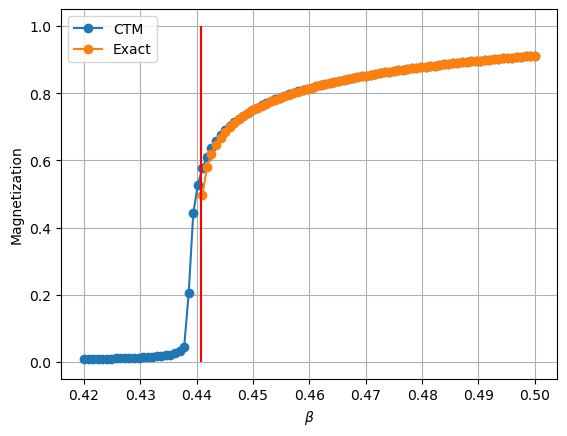

In [52]:
plt.plot(x,list_mag,'o-',label='CTM')
plt.plot(x,exact_mag(x),'o-',label='Exact')
plt.vlines(np.log(1 + np.sqrt(2))/2.,0,1,'r')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnetization')
plt.legend()
plt.grid()

## The critical point

You can try to see what happens at the critical point (or close to it) if you increase the bond dimension



In [ ]:
d_tol=1.e-10

numiter_max=5000
list_mag=[]
beta_start=0.42
b_fin=0.5
num_steps=100
d=2
beta = np.log(1+np.sqrt(2))/2+0.0001
a=local_tensor_T(beta,0)
b=a.copy()
b[1,:,:,:]=-b[1,:,:,:]
C = a[:,:,0,0]
T = a[:,:,0,:]
chi = d
T = T+T.transpose([2,1,0])
norm = compute_norm(C,T,a)
C= C/norm**(1/9)
T = T/norm**(1/9)
for chi_max in [4,8,16,32,64]:
    C,T,chi,k= iterate_till_convergence(C,T,a,d,chi,chi_max,d_tol,conv_crit,numiter_max)
    magnetization = compute_mag(C,T,a,b)
    norm = compute_norm(C,T,a)
    print('Iter: %d, Norm : %g, Mag : %g, Chi: %d)'%(k,norm, magnetization,chi))
    list_mag.append(magnetization)


Iteration : 1, error =1.02049
Iteration : 2, error =0.0579216
Iteration : 3, error =0.0388811
Iteration : 4, error =0.0288061
Iteration : 5, error =0.02272
Iteration : 6, error =0.0186381
Iteration : 7, error =0.0157096
Iteration : 8, error =0.0135074
Iteration : 9, error =0.0117928
Iteration : 10, error =0.0104215
Iteration : 11, error =0.00930109
Iteration : 12, error =0.00836954
Iteration : 13, error =0.0075837
Iteration : 14, error =0.00691258
Iteration : 15, error =0.00633337
Iteration : 16, error =0.00582889
Iteration : 17, error =0.00538597
Iteration : 18, error =0.00499434
Iteration : 19, error =0.00464586
Iteration : 20, error =0.00433404
Iteration : 21, error =0.00405358
Iteration : 22, error =0.00380018
Iteration : 23, error =0.00357027
Iteration : 24, error =0.00336085
Iteration : 25, error =0.00316944
Iteration : 26, error =0.00299393
Iteration : 27, error =0.00283249
Iteration : 28, error =0.00268361
Iteration : 29, error =0.00254594
Iteration : 30, error =0.00241833
Iter

Iteration : 39, error =0.00102027
Iteration : 40, error =0.00100319
Iteration : 41, error =0.000986672
Iteration : 42, error =0.000970682
Iteration : 43, error =0.000955183
Iteration : 44, error =0.000940146
Iteration : 45, error =0.000925542
Iteration : 46, error =0.000911347
Iteration : 47, error =0.000897538
Iteration : 48, error =0.000884094
Iteration : 49, error =0.000870997
Iteration : 50, error =0.000858229
Iteration : 51, error =0.000845775
Iteration : 52, error =0.00083362
Iteration : 53, error =0.000821751
Iteration : 54, error =0.000810156
Iteration : 55, error =0.000798823
Iteration : 56, error =0.000787741
Iteration : 57, error =0.000776901
Iteration : 58, error =0.000766293
Iteration : 59, error =0.00075591
Iteration : 60, error =0.000745742
Iteration : 61, error =0.000735782
Iteration : 62, error =0.000726023
Iteration : 63, error =0.000716459
Iteration : 64, error =0.000707083
Iteration : 65, error =0.000697889
Iteration : 66, error =0.000688871
Iteration : 67, error =0

Iteration : 274, error =9.19905e-05
Iteration : 275, error =9.12294e-05
Iteration : 276, error =9.04751e-05
Iteration : 277, error =8.97275e-05
Iteration : 278, error =8.89865e-05
Iteration : 279, error =8.82521e-05
Iteration : 280, error =8.75242e-05
Iteration : 281, error =8.68028e-05
Iteration : 282, error =8.60877e-05
Iteration : 283, error =8.53789e-05
Iteration : 284, error =8.46764e-05
Iteration : 285, error =8.39801e-05
Iteration : 286, error =8.32899e-05
Iteration : 287, error =8.26057e-05
Iteration : 288, error =8.19276e-05
Iteration : 289, error =8.12554e-05
Iteration : 290, error =8.05891e-05
Iteration : 291, error =7.99287e-05
Iteration : 292, error =7.9274e-05
Iteration : 293, error =7.8625e-05
Iteration : 294, error =7.79817e-05
Iteration : 295, error =7.7344e-05
Iteration : 296, error =7.67118e-05
Iteration : 297, error =7.60852e-05
Iteration : 298, error =7.5464e-05
Iteration : 299, error =7.48481e-05
Iteration : 300, error =7.42376e-05
Iteration : 301, error =7.36325e

Iteration : 537, error =1.13933e-05
Iteration : 538, error =1.13053e-05
Iteration : 539, error =1.12179e-05
Iteration : 540, error =1.11312e-05
Iteration : 541, error =1.10451e-05
Iteration : 542, error =1.09598e-05
Iteration : 543, error =1.08751e-05
Iteration : 544, error =1.07911e-05
Iteration : 545, error =1.07077e-05
Iteration : 546, error =1.0625e-05
Iteration : 547, error =1.05429e-05
Iteration : 548, error =1.04615e-05
Iteration : 549, error =1.03807e-05
Iteration : 550, error =1.03005e-05
Iteration : 551, error =1.02209e-05
Iteration : 552, error =1.0142e-05
Iteration : 553, error =1.00637e-05
Iteration : 554, error =9.98598e-06
Iter: 554, Norm : 1.48016, Mag : 0.484896, Chi: 8)
Iteration : 1, error =1.2043
Iteration : 2, error =0.00349717
Iteration : 3, error =0.00244659
Iteration : 4, error =0.00191237
Iteration : 5, error =0.00161273
Iteration : 6, error =0.0014122
Iteration : 7, error =0.00128277
Iteration : 8, error =0.00120079
Iteration : 9, error =0.00111099
Iteration :

Iteration : 229, error =0.000154807
Iteration : 230, error =0.000154233
Iteration : 231, error =0.000153661
Iteration : 232, error =0.000153092
Iteration : 233, error =0.000152526
Iteration : 234, error =0.000151963
Iteration : 235, error =0.000151402
Iteration : 236, error =0.000150845
Iteration : 237, error =0.00015029
Iteration : 238, error =0.000149738
Iteration : 239, error =0.000149189
Iteration : 240, error =0.000148642
Iteration : 241, error =0.000148098
Iteration : 242, error =0.000147557
Iteration : 243, error =0.000147019
Iteration : 244, error =0.000146483
Iteration : 245, error =0.000145949
Iteration : 246, error =0.000145419
Iteration : 247, error =0.000144891
Iteration : 248, error =0.000144365
Iteration : 249, error =0.000143842
Iteration : 250, error =0.000143321
Iteration : 251, error =0.000142803
Iteration : 252, error =0.000142288
Iteration : 253, error =0.000141775
Iteration : 254, error =0.000141264
Iteration : 255, error =0.000140756
Iteration : 256, error =0.000

Iteration : 484, error =6.64312e-05
Iteration : 485, error =6.62287e-05
Iteration : 486, error =6.60269e-05
Iteration : 487, error =6.58259e-05
Iteration : 488, error =6.56255e-05
Iteration : 489, error =6.54258e-05
Iteration : 490, error =6.52269e-05
Iteration : 491, error =6.50286e-05
Iteration : 492, error =6.4831e-05
Iteration : 493, error =6.46341e-05
Iteration : 494, error =6.44379e-05
Iteration : 495, error =6.42423e-05
Iteration : 496, error =6.40475e-05
Iteration : 497, error =6.38533e-05
Iteration : 498, error =6.36598e-05
Iteration : 499, error =6.34669e-05
Iteration : 500, error =6.32748e-05
Iteration : 501, error =6.30832e-05
Iteration : 502, error =6.28924e-05
Iteration : 503, error =6.27022e-05
Iteration : 504, error =6.25127e-05
Iteration : 505, error =6.23238e-05
Iteration : 506, error =6.21356e-05
Iteration : 507, error =6.1948e-05
Iteration : 508, error =6.1761e-05
Iteration : 509, error =6.15747e-05
Iteration : 510, error =6.13891e-05
Iteration : 511, error =6.1204e

Iteration : 737, error =3.17106e-05
Iteration : 738, error =3.16211e-05
Iteration : 739, error =3.15318e-05
Iteration : 740, error =3.14429e-05
Iteration : 741, error =3.13542e-05
Iteration : 742, error =3.12657e-05
Iteration : 743, error =3.11776e-05
Iteration : 744, error =3.10896e-05
Iteration : 745, error =3.1002e-05
Iteration : 746, error =3.09146e-05
Iteration : 747, error =3.08275e-05
Iteration : 748, error =3.07407e-05
Iteration : 749, error =3.06541e-05
Iteration : 750, error =3.05677e-05
Iteration : 751, error =3.04817e-05
Iteration : 752, error =3.03959e-05
Iteration : 753, error =3.03103e-05
Iteration : 754, error =3.0225e-05
Iteration : 755, error =3.014e-05
Iteration : 756, error =3.00552e-05
Iteration : 757, error =2.99707e-05
Iteration : 758, error =2.98864e-05
Iteration : 759, error =2.98023e-05
Iteration : 760, error =2.97186e-05
Iteration : 761, error =2.9635e-05
Iteration : 762, error =2.95518e-05
Iteration : 763, error =2.94687e-05
Iteration : 764, error =2.9386e-0

Iteration : 978, error =1.62458e-05
Iteration : 979, error =1.62014e-05
Iteration : 980, error =1.61572e-05
Iteration : 981, error =1.61131e-05
Iteration : 982, error =1.60691e-05
Iteration : 983, error =1.60252e-05
Iteration : 984, error =1.59814e-05
Iteration : 985, error =1.59378e-05
Iteration : 986, error =1.58943e-05
Iteration : 987, error =1.58509e-05
Iteration : 988, error =1.58077e-05
Iteration : 989, error =1.57645e-05
Iteration : 990, error =1.57215e-05
Iteration : 991, error =1.56786e-05
Iteration : 992, error =1.56358e-05
Iteration : 993, error =1.55932e-05
Iteration : 994, error =1.55507e-05
Iteration : 995, error =1.55083e-05
Iteration : 996, error =1.5466e-05
Iteration : 997, error =1.54238e-05
Iteration : 998, error =1.53817e-05
Iteration : 999, error =1.53398e-05
Iteration : 1000, error =1.5298e-05
Iteration : 1001, error =1.52563e-05
Iteration : 1002, error =1.52147e-05
Iteration : 1003, error =1.51732e-05
Iteration : 1004, error =1.51319e-05
Iteration : 1005, error =

Iteration : 68, error =0.000142644
Iteration : 69, error =0.000141481
Iteration : 70, error =0.000140343
Iteration : 71, error =0.000139231
Iteration : 72, error =0.000138144
Iteration : 73, error =0.000137081
Iteration : 74, error =0.000136041
Iteration : 75, error =0.000135023
Iteration : 76, error =0.000134027
Iteration : 77, error =0.000133052
Iteration : 78, error =0.000132098
Iteration : 79, error =0.000131163
Iteration : 80, error =0.000130247
Iteration : 81, error =0.000129349
Iteration : 82, error =0.00012847
Iteration : 83, error =0.000127607
Iteration : 84, error =0.000126762
Iteration : 85, error =0.000125933
Iteration : 86, error =0.000125119
Iteration : 87, error =0.000124321
Iteration : 88, error =0.000123537
Iteration : 89, error =0.000122768
Iteration : 90, error =0.000122012
Iteration : 91, error =0.00012127
Iteration : 92, error =0.000120541
Iteration : 93, error =0.000119825
Iteration : 94, error =0.000119121
Iteration : 95, error =0.00011843
Iteration : 96, error =

Iteration : 302, error =6.1734e-05
Iteration : 303, error =6.16048e-05
Iteration : 304, error =6.14761e-05
Iteration : 305, error =6.1348e-05
Iteration : 306, error =6.12203e-05
Iteration : 307, error =6.10931e-05
Iteration : 308, error =6.09665e-05
Iteration : 309, error =6.08403e-05
Iteration : 310, error =6.07146e-05
Iteration : 311, error =6.05894e-05
Iteration : 312, error =6.04647e-05
Iteration : 313, error =6.03405e-05
Iteration : 314, error =6.02167e-05
Iteration : 315, error =6.00935e-05
Iteration : 316, error =5.99707e-05
Iteration : 317, error =5.98483e-05
Iteration : 318, error =5.97265e-05
Iteration : 319, error =5.96051e-05
Iteration : 320, error =5.94841e-05
Iteration : 321, error =5.93636e-05
Iteration : 322, error =5.92436e-05
Iteration : 323, error =5.91239e-05
Iteration : 324, error =5.90048e-05
Iteration : 325, error =5.8886e-05
Iteration : 326, error =5.87678e-05
Iteration : 327, error =5.86499e-05
Iteration : 328, error =5.85325e-05
Iteration : 329, error =5.84155

Iteration : 537, error =4.03016e-05
Iteration : 538, error =4.02353e-05
Iteration : 539, error =4.01691e-05
Iteration : 540, error =4.01031e-05
Iteration : 541, error =4.00372e-05
Iteration : 542, error =3.99714e-05
Iteration : 543, error =3.99058e-05
Iteration : 544, error =3.98403e-05
Iteration : 545, error =3.9775e-05
Iteration : 546, error =3.97098e-05
Iteration : 547, error =3.96447e-05
Iteration : 548, error =3.95798e-05
Iteration : 549, error =3.9515e-05
Iteration : 550, error =3.94504e-05
Iteration : 551, error =3.93859e-05
Iteration : 552, error =3.93215e-05
Iteration : 553, error =3.92573e-05
Iteration : 554, error =3.91932e-05
Iteration : 555, error =3.91292e-05
Iteration : 556, error =3.90654e-05
Iteration : 557, error =3.90017e-05
Iteration : 558, error =3.89382e-05
Iteration : 559, error =3.88747e-05
Iteration : 560, error =3.88114e-05
Iteration : 561, error =3.87483e-05
Iteration : 562, error =3.86852e-05
Iteration : 563, error =3.86223e-05
Iteration : 564, error =3.8559

Iteration : 787, error =2.72043e-05
Iteration : 788, error =2.7163e-05
Iteration : 789, error =2.71219e-05
Iteration : 790, error =2.70808e-05
Iteration : 791, error =2.70397e-05
Iteration : 792, error =2.69988e-05
Iteration : 793, error =2.69579e-05
Iteration : 794, error =2.69171e-05
Iteration : 795, error =2.68763e-05
Iteration : 796, error =2.68356e-05
Iteration : 797, error =2.6795e-05
Iteration : 798, error =2.67545e-05
Iteration : 799, error =2.6714e-05
Iteration : 800, error =2.66736e-05
Iteration : 801, error =2.66333e-05
Iteration : 802, error =2.6593e-05
Iteration : 803, error =2.65529e-05
Iteration : 804, error =2.65127e-05
Iteration : 805, error =2.64727e-05
Iteration : 806, error =2.64327e-05
Iteration : 807, error =2.63928e-05
Iteration : 808, error =2.63529e-05
Iteration : 809, error =2.63132e-05
Iteration : 810, error =2.62734e-05
Iteration : 811, error =2.62338e-05
Iteration : 812, error =2.61942e-05
Iteration : 813, error =2.61547e-05
Iteration : 814, error =2.61153e

Iteration : 1026, error =1.90717e-05
Iteration : 1027, error =1.90439e-05
Iteration : 1028, error =1.90161e-05
Iteration : 1029, error =1.89884e-05
Iteration : 1030, error =1.89607e-05
Iteration : 1031, error =1.8933e-05
Iteration : 1032, error =1.89054e-05
Iteration : 1033, error =1.88779e-05
Iteration : 1034, error =1.88503e-05
Iteration : 1035, error =1.88229e-05
Iteration : 1036, error =1.87954e-05
Iteration : 1037, error =1.8768e-05
Iteration : 1038, error =1.87407e-05
Iteration : 1039, error =1.87134e-05
Iteration : 1040, error =1.86861e-05
Iteration : 1041, error =1.86589e-05
Iteration : 1042, error =1.86317e-05
Iteration : 1043, error =1.86046e-05
Iteration : 1044, error =1.85775e-05
Iteration : 1045, error =1.85505e-05
Iteration : 1046, error =1.85234e-05
Iteration : 1047, error =1.84965e-05
Iteration : 1048, error =1.84696e-05
Iteration : 1049, error =1.84427e-05
Iteration : 1050, error =1.84158e-05
Iteration : 1051, error =1.83891e-05
Iteration : 1052, error =1.83623e-05
Ite

Iteration : 1259, error =1.36247e-05
Iteration : 1260, error =1.36053e-05
Iteration : 1261, error =1.35858e-05
Iteration : 1262, error =1.35664e-05
Iteration : 1263, error =1.3547e-05
Iteration : 1264, error =1.35277e-05
Iteration : 1265, error =1.35084e-05
Iteration : 1266, error =1.34891e-05
Iteration : 1267, error =1.34698e-05
Iteration : 1268, error =1.34506e-05
Iteration : 1269, error =1.34314e-05
Iteration : 1270, error =1.34122e-05
Iteration : 1271, error =1.33931e-05
Iteration : 1272, error =1.3374e-05
Iteration : 1273, error =1.33549e-05
Iteration : 1274, error =1.33358e-05
Iteration : 1275, error =1.33168e-05
Iteration : 1276, error =1.32978e-05
Iteration : 1277, error =1.32788e-05
Iteration : 1278, error =1.32599e-05
Iteration : 1279, error =1.3241e-05
Iteration : 1280, error =1.32221e-05
Iteration : 1281, error =1.32032e-05
Iteration : 1282, error =1.31844e-05
Iteration : 1283, error =1.31656e-05
Iteration : 1284, error =1.31468e-05
Iteration : 1285, error =1.31281e-05
Iter

Iteration : 8, error =0.000265308
Iteration : 9, error =0.000243862
Iteration : 10, error =0.000225683
Iteration : 11, error =0.000210077
Iteration : 12, error =0.000197119
Iteration : 13, error =0.000183746
Iteration : 14, error =0.000177543
Iteration : 15, error =0.000168265
Iteration : 16, error =0.000159691
Iteration : 17, error =0.000153976
Iteration : 18, error =0.000148219
Iteration : 19, error =0.000143016
Iteration : 20, error =0.000137915
Iteration : 21, error =0.000133088
Iteration : 22, error =0.00012954
Iteration : 23, error =0.000125738
Iteration : 24, error =0.000122157
Iteration : 25, error =0.000118796
Iteration : 26, error =0.000115714
Iteration : 27, error =0.000112736
Iteration : 28, error =0.000109483
Iteration : 29, error =0.000106708
Iteration : 30, error =0.000104977
Iteration : 31, error =0.000102822
Iteration : 32, error =0.000102208
Iteration : 33, error =0.000102997
Iteration : 34, error =0.000101053
Iteration : 35, error =9.84167e-05
Iteration : 36, error =

Iteration : 242, error =3.19332e-05
Iteration : 243, error =3.18589e-05
Iteration : 244, error =3.17835e-05
Iteration : 245, error =3.17071e-05
Iteration : 246, error =3.16298e-05
Iteration : 247, error =3.15512e-05
Iteration : 248, error =3.14707e-05
Iteration : 249, error =3.1386e-05
Iteration : 250, error =3.12894e-05
Iteration : 251, error =3.11462e-05
Iteration : 252, error =3.09076e-05
Iteration : 253, error =3.09485e-05
Iteration : 254, error =3.09654e-05
Iteration : 255, error =3.09129e-05
Iteration : 256, error =3.08451e-05
Iteration : 257, error =3.07744e-05
Iteration : 258, error =3.07038e-05
Iteration : 259, error =3.06333e-05
Iteration : 260, error =3.05624e-05
Iteration : 261, error =3.04911e-05
Iteration : 262, error =3.04195e-05
Iteration : 263, error =3.03477e-05
Iteration : 264, error =3.02758e-05
Iteration : 265, error =3.02045e-05
Iteration : 266, error =3.01335e-05
Iteration : 267, error =3.00626e-05
Iteration : 268, error =2.99921e-05
Iteration : 269, error =2.992

Iteration : 472, error =2.07591e-05
Iteration : 473, error =2.0728e-05
Iteration : 474, error =2.0697e-05
Iteration : 475, error =2.06661e-05
Iteration : 476, error =2.06352e-05
Iteration : 477, error =2.06045e-05
Iteration : 478, error =2.05738e-05
Iteration : 479, error =2.05432e-05
Iteration : 480, error =2.05127e-05
Iteration : 481, error =2.04823e-05
Iteration : 482, error =2.04519e-05
Iteration : 483, error =2.04217e-05
Iteration : 484, error =2.03915e-05
Iteration : 485, error =2.03614e-05
Iteration : 486, error =2.03313e-05
Iteration : 487, error =2.03014e-05
Iteration : 488, error =2.02715e-05
Iteration : 489, error =2.02417e-05
Iteration : 490, error =2.02119e-05
Iteration : 491, error =2.01823e-05
Iteration : 492, error =2.01527e-05
Iteration : 493, error =2.01232e-05
Iteration : 494, error =2.00937e-05
Iteration : 495, error =2.00644e-05
Iteration : 496, error =2.00351e-05
Iteration : 497, error =2.00059e-05
Iteration : 498, error =1.99767e-05
Iteration : 499, error =1.9947

Iteration : 707, error =1.50911e-05
Iteration : 708, error =1.50721e-05
Iteration : 709, error =1.50532e-05
Iteration : 710, error =1.50342e-05
Iteration : 711, error =1.50153e-05
Iteration : 712, error =1.49965e-05
Iteration : 713, error =1.49777e-05
Iteration : 714, error =1.49589e-05
Iteration : 715, error =1.49401e-05
Iteration : 716, error =1.49214e-05
Iteration : 717, error =1.49027e-05
Iteration : 718, error =1.4884e-05
Iteration : 719, error =1.48654e-05
Iteration : 720, error =1.48468e-05
Iteration : 721, error =1.48282e-05
Iteration : 722, error =1.48096e-05
Iteration : 723, error =1.47911e-05
Iteration : 724, error =1.47726e-05
Iteration : 725, error =1.47542e-05
Iteration : 726, error =1.47358e-05
Iteration : 727, error =1.47174e-05
Iteration : 728, error =1.4699e-05
Iteration : 729, error =1.46807e-05
Iteration : 730, error =1.46624e-05
Iteration : 731, error =1.46441e-05
Iteration : 732, error =1.46259e-05
Iteration : 733, error =1.46077e-05
Iteration : 734, error =1.4589

Iteration : 943, error =1.13468e-05
Iteration : 944, error =1.13336e-05
Iteration : 945, error =1.13203e-05
Iteration : 946, error =1.13071e-05
Iteration : 947, error =1.12939e-05
Iteration : 948, error =1.12807e-05
Iteration : 949, error =1.12675e-05
Iteration : 950, error =1.12543e-05
Iteration : 951, error =1.12412e-05
Iteration : 952, error =1.12281e-05
Iteration : 953, error =1.1215e-05
Iteration : 954, error =1.12019e-05
Iteration : 955, error =1.11888e-05
Iteration : 956, error =1.11758e-05
Iteration : 957, error =1.11627e-05


## Finite entanglement scaling
And plot the deviation from the exact magnetization in log-log scale with respect to the bond dimension $\chi$ to unveil the ***finite entanglement scaling***

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


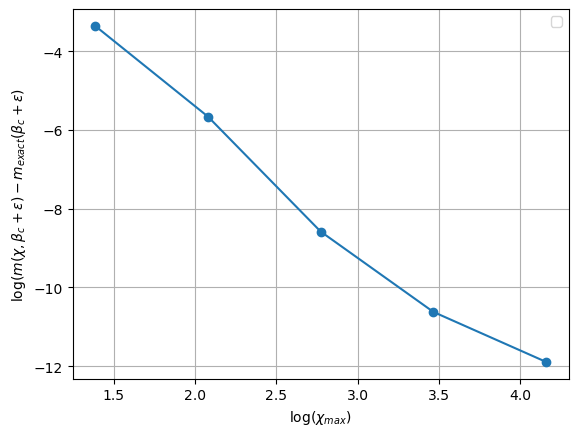

In [57]:
plt.plot(np.log([4,8,16,32,64]),np.log(list_mag-exact_mag(beta)),'o-')
plt.xlabel(r'$\log(\chi_{max})$')
plt.ylabel(r'$\log(m(\chi,\beta_c+\epsilon)-m_{exact}(\beta_c+\epsilon)$')
plt.legend()
plt.grid()